In [21]:
import afq_transform as afqt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
import sgl
import timeit

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

%matplotlib inline

plt.style.use('ggplot')

In [3]:
nodes = pd.read_csv('data/nodes.csv')

In [4]:
targets = pd.read_csv('data/subjects.csv', index_col='subjectID').drop(['Unnamed: 0'], axis='columns')
y = targets['class']
y = y.map(lambda h: int(h == 'ALS')).values
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [5]:
transformer = afqt.AFQFeatureTransformer()
X, groups, cols = transformer.transform(nodes)

In [6]:
col_vals = cols.get_values()

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [8]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
pca = PCA(n_components=20)
pca.fit(Xtrain)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [10]:
print(np.sum(pca.explained_variance_ratio_))
pca.explained_variance_ratio_

0.728941987368


array([ 0.14031608,  0.05624621,  0.04481239,  0.03978049,  0.03919443,
        0.03615555,  0.03549814,  0.03300973,  0.03107433,  0.02963106,
        0.0286483 ,  0.02787821,  0.02603778,  0.02505599,  0.0242974 ,
        0.0236219 ,  0.02319755,  0.02251327,  0.02147168,  0.0205015 ])

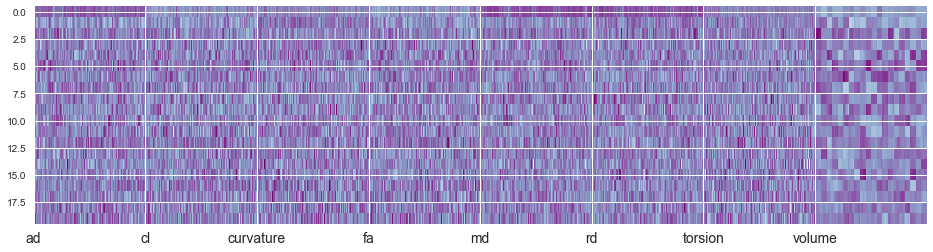

In [11]:
fig = plt.figure()
fig, ax = plt.subplots(1,1, figsize=(16, 4))
_ = ax.imshow(pca.components_, aspect='auto', cmap='BuPu')
_ = ax.set_xticklabels([''] + list(cols.levels[0]))
_ = ax.tick_params(axis='x', which='major', labelsize=14)
_ = ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))

In [16]:
ge = afqt.GroupExtractor(groups=groups)
clf = LogisticRegression(penalty='l1', solver='saga', max_iter=500)

steps = [
    ('scale', StandardScaler()),
    ('group', ge),
    ('lasso', clf),
]

pipeline = Pipeline(steps)

In [64]:
params_groups = np.arange(20)
params_lasso = np.logspace(-4, 3, 10)

param_grid = {
    'group__extract': params_groups,
    'lasso__C': params_lasso
}

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

group_logreg_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring=scoring, cv=5, refit='AUC')

In [65]:
group_logreg_cv.fit(Xtrain, ytrain)

/Users/Adam/anaconda/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Adam/anaconda/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Adam/anaconda/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Adam/anaconda/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Adam/anaconda/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached w

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('group', GroupExtractor(extract=None, groups=array([  0,   0, ..., 159, 159]))), ('lasso', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lasso__C': array([  1.00000e-04,   5.99484e-04,   3.59381e-03,   2.15443e-02,
         1.29155e-01,   7.74264e-01,   4.64159e+00,   2.78256e+01,
         1.66810e+02,   1.00000e+03]), 'group__extract': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'Accuracy': make_scorer(accuracy_

In [66]:
results = group_logreg_cv.cv_results_

In [67]:
results

/Users/Adam/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_AUC'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Adam/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_Accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Adam/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_AUC'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Adam/anaconda/lib/python3.5/site-pa

{'mean_fit_time': array([ 0.08149457,  0.05262604,  0.0773056 ,  0.08415699,  0.05834765,
         0.08611436,  0.13239598,  0.09844713,  0.133008  ,  0.19455495,
         0.07167401,  0.087082  ,  0.06314783,  0.0581234 ,  0.09451904,
         0.12450376,  0.16817508,  0.19446077,  0.16891756,  0.13408799,
         0.07611485,  0.05214281,  0.05016952,  0.05613065,  0.06526389,
         0.14020262,  0.11766591,  0.13862128,  0.16029897,  0.11567016,
         0.08662095,  0.0555316 ,  0.05048537,  0.06480322,  0.05639977,
         0.15028539,  0.11511235,  0.1006043 ,  0.14659424,  0.13682284,
         0.10307341,  0.09363875,  0.05914521,  0.06933136,  0.06958857,
         0.08854136,  0.11982951,  0.09971657,  0.09318237,  0.0885458 ,
         0.05644922,  0.05955515,  0.06286492,  0.05951519,  0.0635962 ,
         0.21654282,  0.13079543,  0.12328782,  0.1023798 ,  0.10299606,
         0.04993606,  0.05091457,  0.05058336,  0.06436591,  0.05603728,
         0.08467302,  0.09045467, 

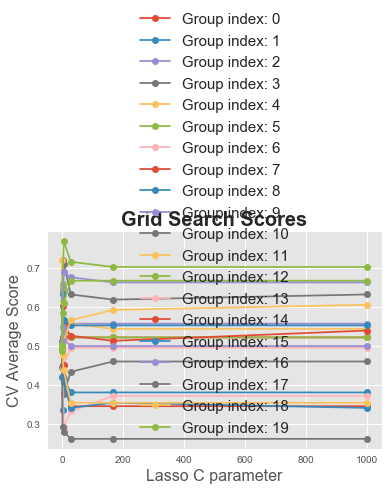

In [68]:
def plot_grid_search(cv_results, score_name, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_' + score_name]
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_' + score_name]
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1, 1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method 
plot_grid_search(
    results, score_name='AUC',
    grid_param_1=params_lasso,
    grid_param_2=params_groups,
    name_param_1='Lasso C parameter',
    name_param_2='Group index'
)

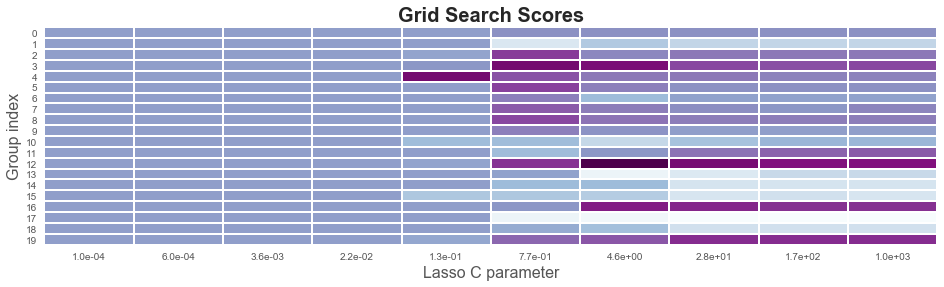

In [69]:
def grid_search_heatmap(cv_results, score_name, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_' + score_name]
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    fig = plt.figure()
    fig, ax = plt.subplots(1,1, figsize=(16, 4))
    
    _ = ax.imshow(scores_mean, aspect='auto', cmap='BuPu')

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel(name_param_2, fontsize=16)

    # Major ticks
    ax.set_xticks(np.arange(0, len(grid_param_1), 1));
    ax.set_yticks(np.arange(0, len(grid_param_2), 1));

    # Labels for major ticks
    ax.set_xticklabels(['{0:3.1e}'.format(i) for i in grid_param_1]);
    ax.set_yticklabels(grid_param_2);

    # Minor ticks
    ax.set_xticks(np.arange(-.5, len(grid_param_1), 1), minor=True);
    ax.set_yticks(np.arange(-.5, len(grid_param_2), 1), minor=True);

    # Gridlines based on minor ticks
    ax.grid('off')
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

# Calling Method 
grid_search_heatmap(
    results, score_name='AUC',
    grid_param_1=params_lasso,
    grid_param_2=params_groups,
    name_param_1='Lasso C parameter',
    name_param_2='Group index'
)

In [76]:
def best_k_groups(cv_results, k, score_name, grid_param_1, grid_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_' + score_name]
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    group_scores = np.max(scores_mean, axis=1)
    max_indices = np.argsort(group_scores)[-1:-k-1:-1]
    max_elements = group_scores[max_indices]
    return list(zip(max_indices, max_elements))
    
    
best_k_groups(
    results, score_name='AUC', k=3,
    grid_param_1=params_lasso,
    grid_param_2=params_groups
)

[(12, 0.76754385964912286), (3, 0.7192982456140351), (4, 0.7192982456140351)]

In [77]:
group_logreg_cv.best_params_

{'group__extract': 12, 'lasso__C': 4.641588833612782}